In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!ls archive

Location1.csv Location2.csv Location3.csv Location4.csv readme.txt


## Exploratory Data Analysis

In [3]:
file_dirs = [
    "archive/Location1.csv", 
    "archive/Location2.csv", 
    "archive/Location3.csv", 
    "archive/Location4.csv"
]

In [4]:
dfs = [
    pd.read_csv(path) for path in file_dirs
]

for df in dfs:
    df["Time"] = pd.to_datetime(df["Time"])
    df.index = df["Time"]

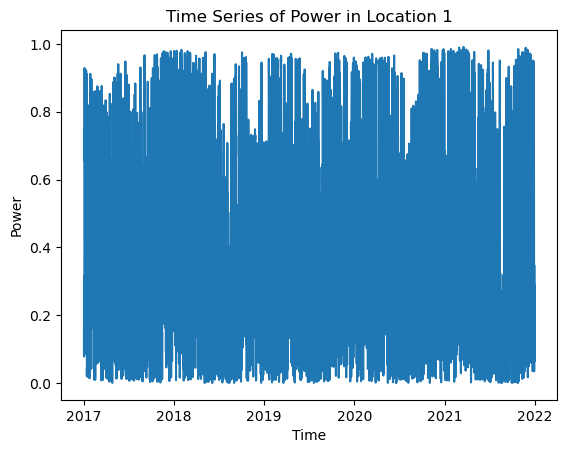

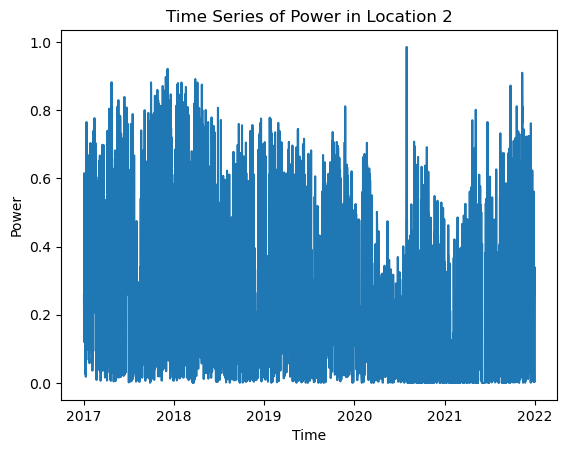

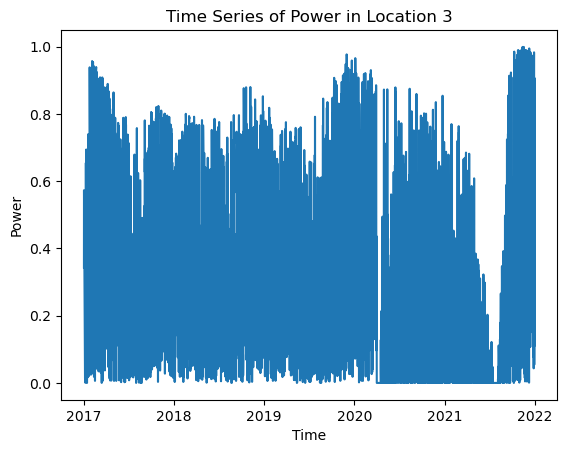

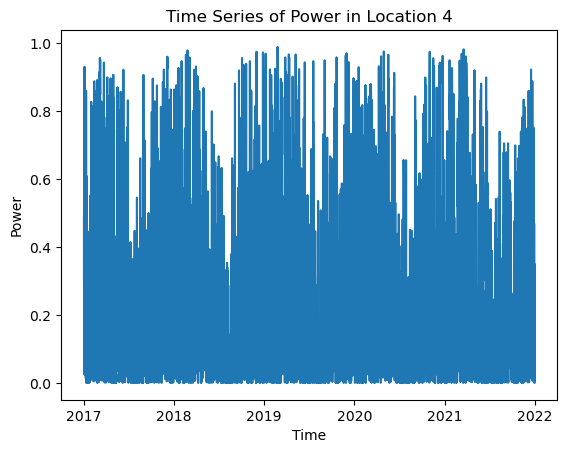

In [5]:
for i, df in enumerate(dfs):
    plt.plot(df["Time"], df["Power"])
    plt.title(f"Time Series of Power in Location {i + 1}")
    plt.xlabel("Time")
    plt.ylabel("Power")
    plt.show()

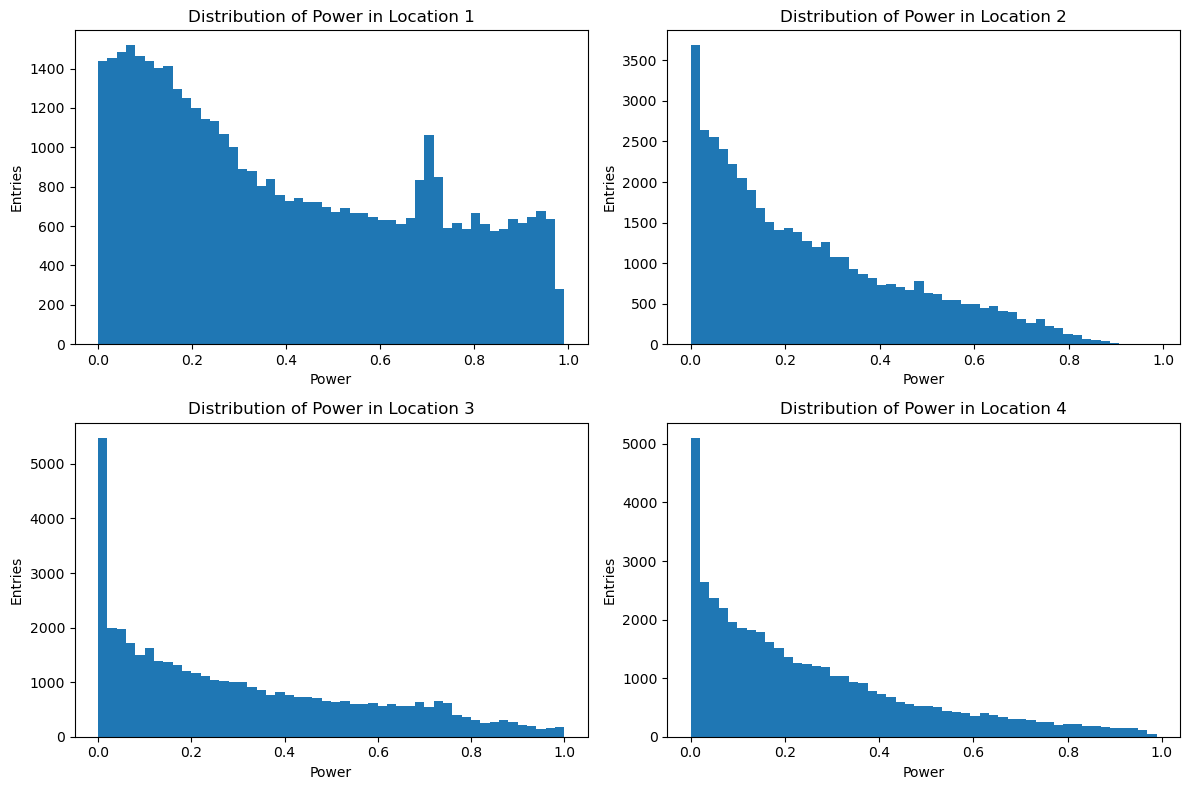

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, df in enumerate(dfs):
    axes[i].hist(df["Power"], bins=50)
    axes[i].set_title(f"Distribution of Power in Location {i + 1}")
    axes[i].set_xlabel("Power")
    axes[i].set_ylabel("Entries")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


The distribution of power looks skewed. Specifically, it looks positively skewed. This shows that the generation of wind power is rarely maximized.

In [7]:
for i, df in enumerate(dfs):
    df['month'] = pd.to_datetime(df['Time']).dt.month

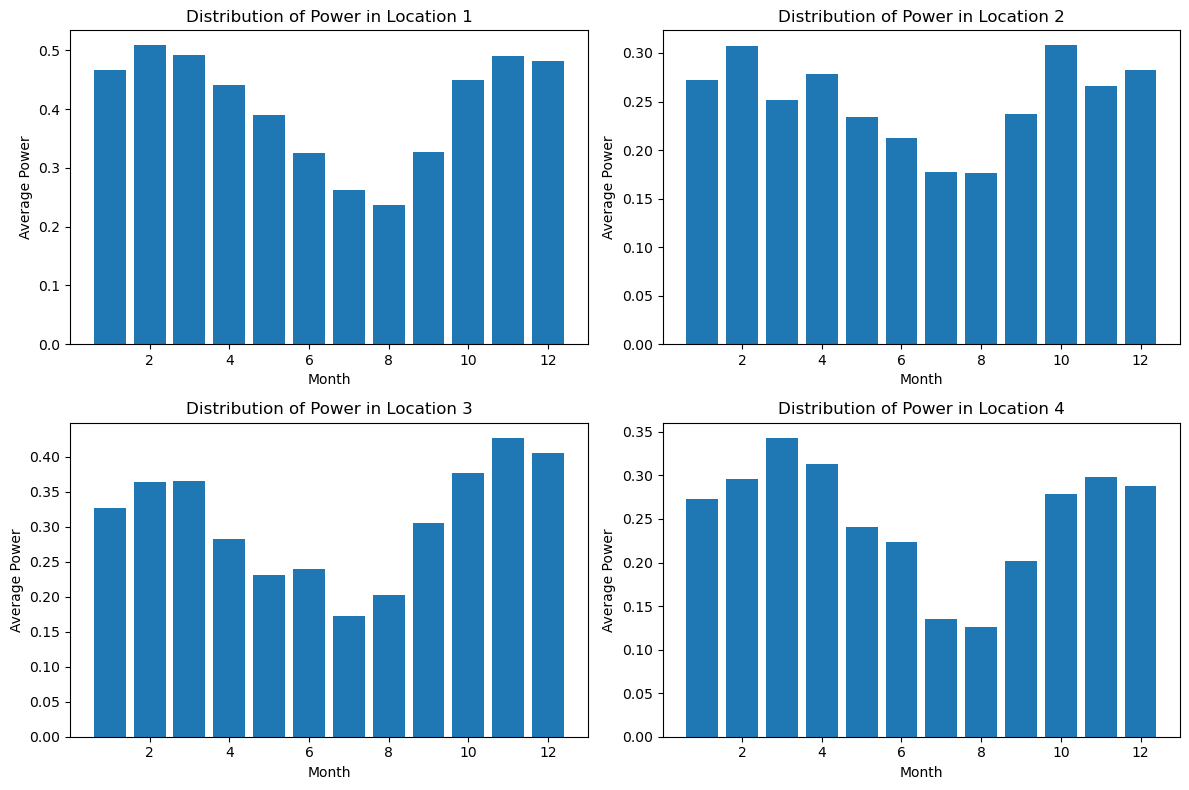

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, df in enumerate(dfs):
    axes[i].bar(
        df.groupby("month")["Power"].mean().index, 
        df.groupby("month")["Power"].mean()
    )
    axes[i].set_title(f"Distribution of Power in Location {i + 1}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Average Power")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Peak generation of power seems to come from February, March, October, and November.

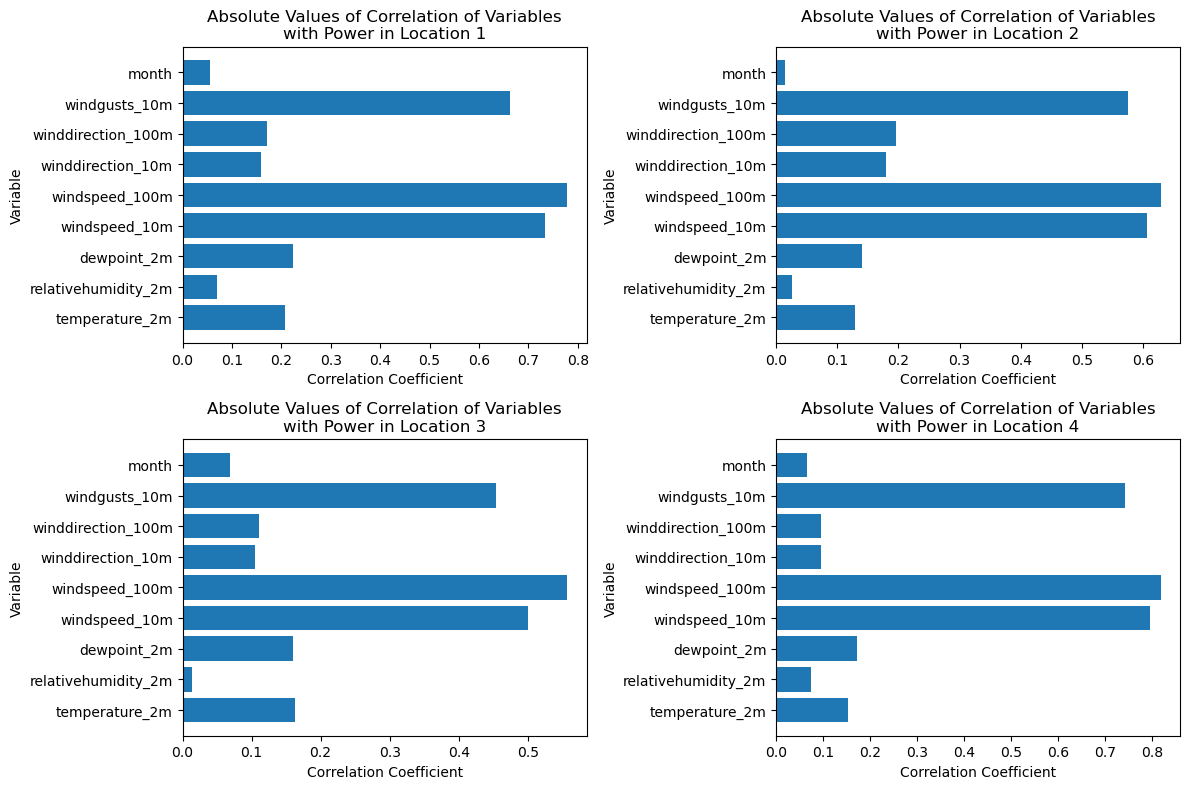

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, df in enumerate(dfs):
    corr_series = df.corr(numeric_only=True)["Power"].drop("Power")
    
    axes[i].barh(
        corr_series.index,
        np.abs(corr_series.values)
    )
    axes[i].set_title(
        "Absolute Values of Correlation of Variables\n"
        f"with Power in Location {i + 1}"
    )
    axes[i].set_xlabel("Correlation Coefficient")
    axes[i].set_ylabel("Variable")

plt.tight_layout()
plt.show()


`windgusts_10`, `windspeed_100m`, and `windspeed_10m` most likely have the most predictive power because they have the largest absolute values with power. However, this still has to be verified with SHAP values after the model has been created.

## Modeling

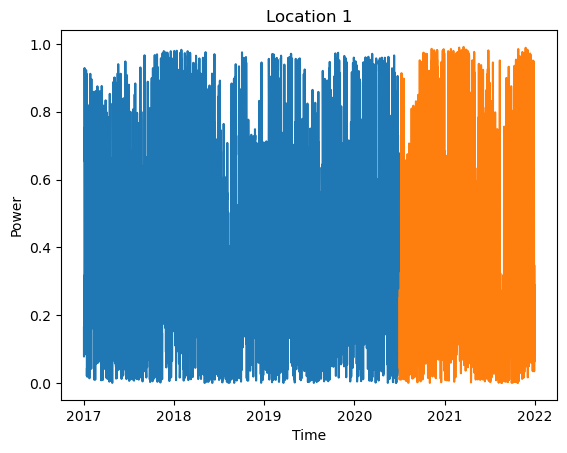

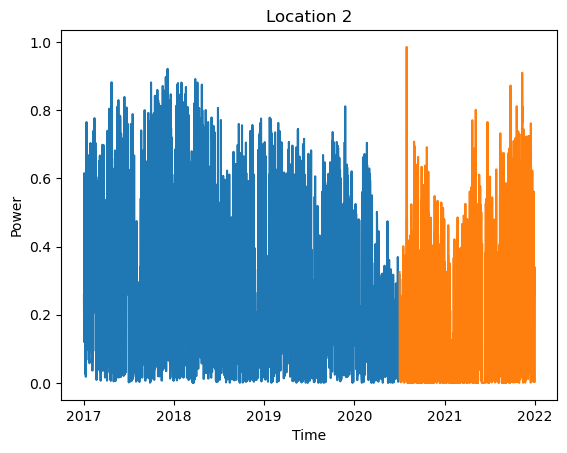

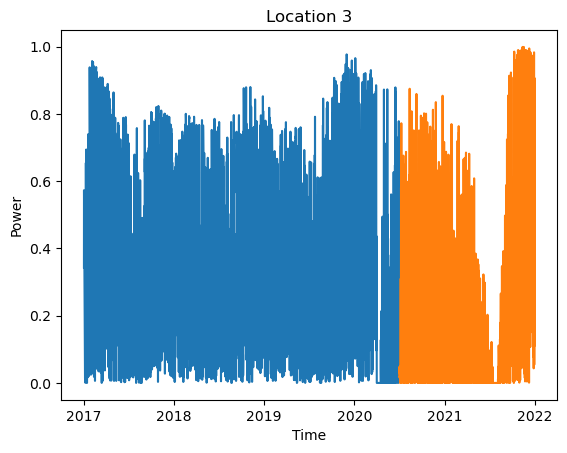

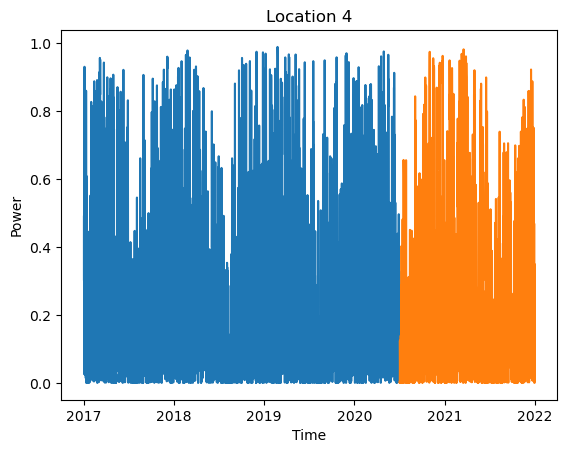

In [10]:
for i, df in enumerate(dfs):
    train_samples = int(len(df) * 0.7)
    df_train = df.head(train_samples)
    df_tail = df.tail(len(df) - train_samples)
    plt.title(
        f"Location {i + 1}"
    )
    plt.xlabel("Time")
    plt.ylabel("Power")
    plt.plot(df_train["Time"], df_train["Power"])
    plt.plot(df_tail["Time"], df_tail["Power"])
    plt.show()

### Last Rows Only

In [11]:
train_n = int(dfs[0].shape[0] * 0.7)
test_n = len(dfs[0]) - train_n

In [12]:
test_n

13141

In [13]:
rmse_vals = []

for i, df in enumerate(dfs):
    df_train = df.head(train_n)
    df_test = df.tail(test_n)

    df_pred = df_train.tail(test_n)
    
    df_rmse = (
        np.mean(
            (df_pred["Power"].values - df_test["Power"].values) ** 2
        ) ** 0.5
    )
    rmse_vals.append(df_rmse)
    print(f"RMSE for Location {i + 1}: {df_rmse}")

RMSE for Location 1: 0.4184904191114299
RMSE for Location 2: 0.2778891526786726
RMSE for Location 3: 0.4182965496868798
RMSE for Location 4: 0.3319251123705546


Text(0.5, 1.0, 'Model Errors')

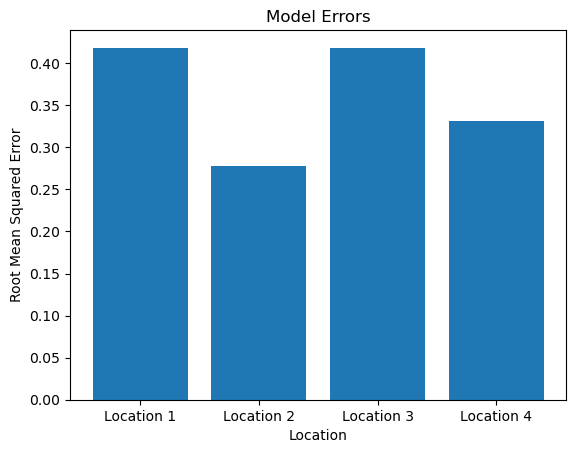

In [14]:
plt.bar(
    ["Location 1", "Location 2", "Location 3", "Location 4"], 
    rmse_vals
)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Location")
plt.title("Model Errors")

The naive model only takes the last 13,141 hours of data in the train set and uses that as a test set.

### Average Hourly

In [15]:
for i, df in enumerate(dfs):
    df['hour'] = pd.to_datetime(df['Time']).dt.hour

In [18]:
df.groupby("hour")["Power"].mean()[5]

0.26176849315068496

In [20]:
rmse_vals = []

for i, df in enumerate(dfs):
    df_train = df.head(train_n)
    df_test = df.tail(test_n)

    hour_guide = df_train.groupby("hour")["Power"].mean()
    df_pred = df_test.copy()
    df_pred["Power"] = 0
    df_pred["Power"] = df_pred["hour"].apply(lambda x: hour_guide[x])
    
    df_rmse = (
        np.mean(
            (df_pred["Power"].values - df_test["Power"].values) ** 2
        ) ** 0.5
    )
    rmse_vals.append(df_rmse)
    print(f"RMSE for Location {i + 1}: {df_rmse}")

RMSE for Location 1: 0.29404157031759853
RMSE for Location 2: 0.20127678944093988
RMSE for Location 3: 0.29197177382374523
RMSE for Location 4: 0.2260488177755965


Text(0.5, 1.0, 'Model Errors')

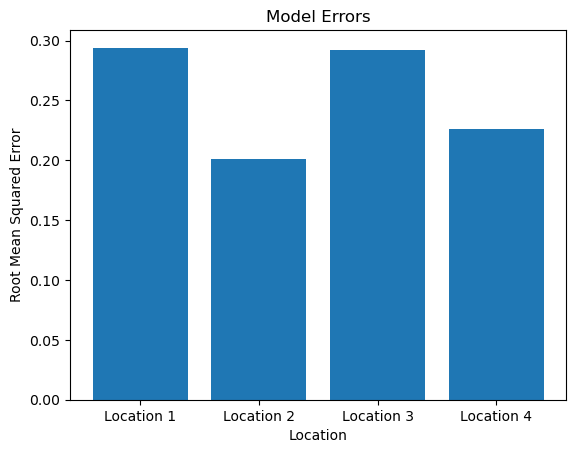

In [21]:
plt.bar(
    ["Location 1", "Location 2", "Location 3", "Location 4"], 
    rmse_vals
)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Location")
plt.title("Model Errors")

Using the average power based on hour in the train set yields better results, but it can still be improved with more sophisticated models.